In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
UberDF  = pd.read_csv("Uber Request Data.csv")

#### Data Cleaning

In [3]:
#Converting the input request time data to proper timestamps

UberDF['Request timestamp'] = UberDF['Request timestamp'].apply(lambda x: datetime.datetime.strptime(x, '%d-%m-%Y %H:%M:%S')
                                                          if ( len(x) > 15 )
                                                          else
                                                          datetime.datetime.strptime(x, '%d/%m/%Y %H:%M')
                                                           )

In [4]:
#Converting the input drop time data to proper timestamps

UberDF['Drop timestamp'] = UberDF[UberDF['Drop timestamp'].notnull()]['Drop timestamp'].apply(lambda x: datetime.datetime.strptime(x, '%d-%m-%Y %H:%M:%S')
                                                          if ( len(x) > 15 )
                                                          else
                                                          datetime.datetime.strptime(x, '%d/%m/%Y %H:%M')
                                                           )

In [5]:
#Getting the input request time data to create a time column

UberDF.loc[:,'Request Time'] = UberDF.loc[:,'Request timestamp'].apply(lambda x: x.time() )
UberDF.loc[:,'Request Time Hour'] = UberDF.loc[:,'Request Time'].apply(lambda x: x.hour)


In [6]:
#Creating Time Slots
UberDF.loc[:,'Time Slot'] = pd.cut(UberDF.loc[:,'Request Time Hour'], [0,6,12,18,24], labels=["Early Morning", "Morning", "After Noon","Late Evening"],right=False)

#### Identifying the most pressing problems for UBER

In [7]:
Incomplete_Trips_DF = UberDF[(UberDF['Drop timestamp'].isnull())]

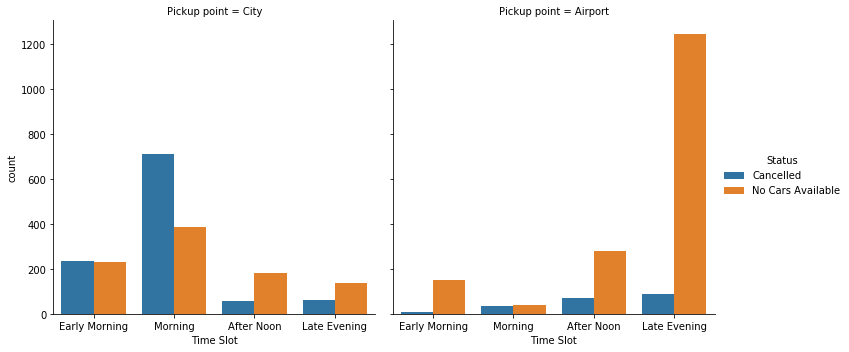

In [8]:
sns.catplot(x="Time Slot", hue ="Status", col="Pickup point", data=Incomplete_Trips_DF, kind="count")

It can be observed from the above plot with the frequency of the requests, that the <b> No Cars Available </b> status is observed the most in the <b> Late Evening </b> time slot for Airport to City and Cancelled Status is observed in the Morning Time Slot for City to Airport

#### Gap between supply and demand

In [9]:
#Calculation of Demand
UberDF.loc[:,'Demand'] =  UberDF['Status'].apply(lambda x: 1 if( x in ['Trip Completed','No Cars Available','Cancelled'] ) else 0)

In [10]:
#Calculation of Supply
UberDF.loc[:,'Supply'] =  UberDF['Status'].apply(lambda x: 1 if( x in ['Trip Completed'] ) else 0)

In [11]:
#Calculation of Gap
UberDF.loc[:,'Gap'] =  UberDF.loc[:,'Demand'] - UberDF.loc[:,'Supply'] 

In [12]:
#Calculation of the Consolidated data frame to hold the important information regarding the requests
Consolidated_DF = UberDF.pivot_table(values=['Demand','Supply','Gap'],columns = [ 'Time Slot','Pickup point'],
                                     aggfunc={'Demand':np.sum,'Supply' :np.sum,'Gap' :np.sum  })
Consolidated_DF = Consolidated_DF.reset_index()
Consolidated_DF.rename(index=str, columns={0: "Number Of Requests",'level_0':"Demand/Supply/Gap"},inplace=True)
Consolidated_DF

,Demand/Supply/Gap,Time Slot,Pickup point,Number Of Requests
0,Demand,Early Morning,Airport,345
1,Demand,Early Morning,City,678
2,Demand,Morning,Airport,473
3,Demand,Morning,City,1599
4,Demand,After Noon,Airport,647
5,Demand,After Noon,City,581
6,Demand,Late Evening,Airport,1773
7,Demand,Late Evening,City,649
8,Supply,Early Morning,Airport,188
9,Supply,Early Morning,City,211


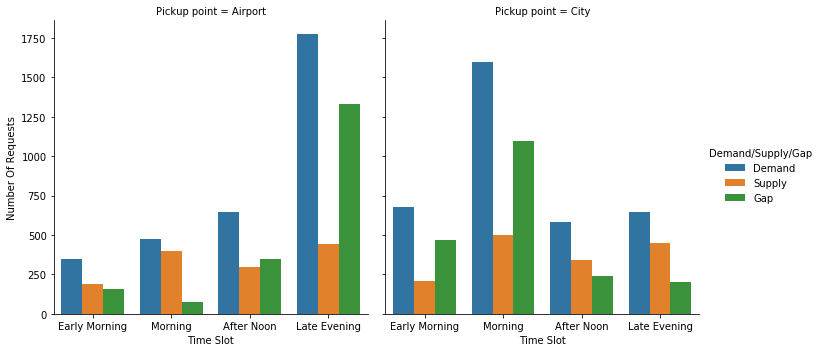

In [13]:
sns.catplot(x="Time Slot", y = "Number Of Requests", hue ="Demand/Supply/Gap", col="Pickup point", data=Consolidated_DF, kind="bar")

 It can be observed from the above plot with the demand and supply gap analysis, that the Gap is observed the most in the <b>Late Evening </b> time slot for Airport to City and in the <b> Morning Time </b> Slot for City to Airport

#### Reason for this issue for the supply-demand gap

Let us look at the cases in which the drivers have cancelled 

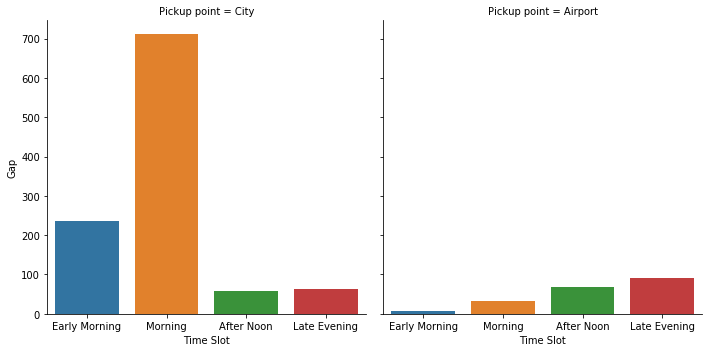

In [22]:
#The Gap for the Cancelled Status
sns.catplot(x="Time Slot", y = "Gap", col="Pickup point", data=UberDF[UberDF['Status']=='Cancelled'], kind="bar", estimator=np.sum)

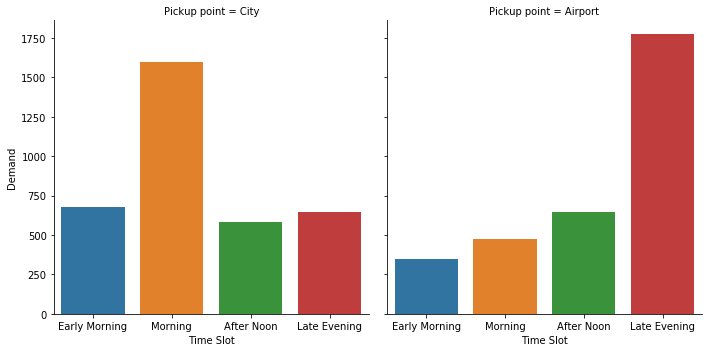

In [31]:
#The Demand for the Cancelled Status
sns.catplot(x="Time Slot", y = "Demand", col="Pickup point",col_order=["City", "Airport"], data=UberDF, kind="bar", estimator=np.sum)

The Spike of Gap in Morning time slot in <b> City to Airport </b> is observed because there is no equal Demand in the <b> Morning and Afternoon </b> time slots for the driver’s return trip from <b> Airport to City </b>

Let us look at the cases in which there are no cars available

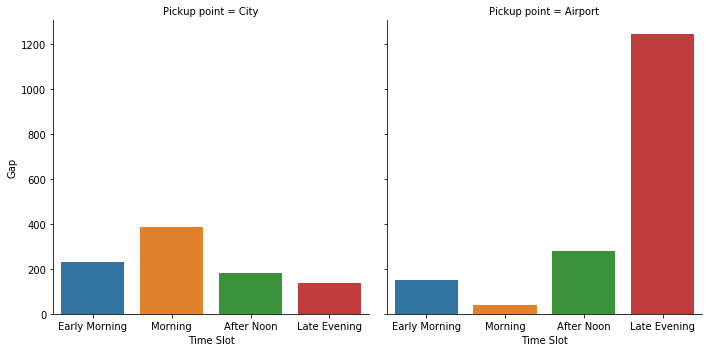

In [52]:
sns.catplot(x="Time Slot", y = "Gap", col="Pickup point", data=UberDF[UberDF['Status']=='No Cars Available'], kind="bar", estimator=np.sum)

In [54]:
#Calculating the Drop time to observe the patterns of the Drivers
UberDF.loc[:,'Drop Time'] = UberDF[UberDF['Drop timestamp'].notnull()].loc[:,'Drop timestamp'].apply(lambda x: x.time() )
UberDF.loc[:,'Drop Time Hour'] = UberDF[UberDF['Drop timestamp'].notnull()].loc[:,'Drop Time'].apply(lambda x: x.hour)
UberDF.loc[:,'Drop Time Slot'] = pd.cut(UberDF[UberDF['Drop timestamp'].notnull()].loc[:,'Drop Time Hour'], [0,6,12,18,24], labels=["Early Morning", "Morning", "After Noon","Late Evening"],right=False)

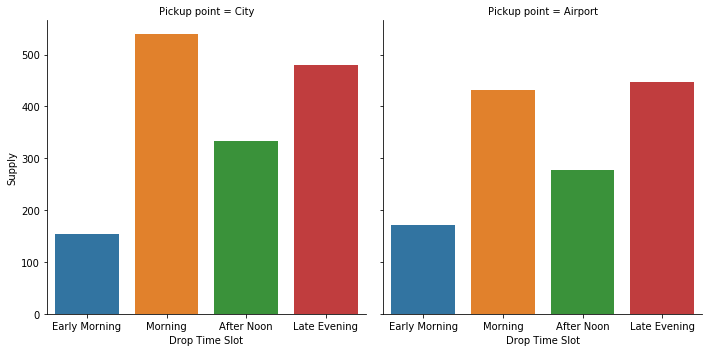

In [55]:
# Drop Time Slots of supply
sns.catplot(x="Drop Time Slot", y = "Supply", col="Pickup point",col_order=["City", "Airport"], data=UberDF[UberDF['Gap']==0], kind="bar", estimator=np.sum)

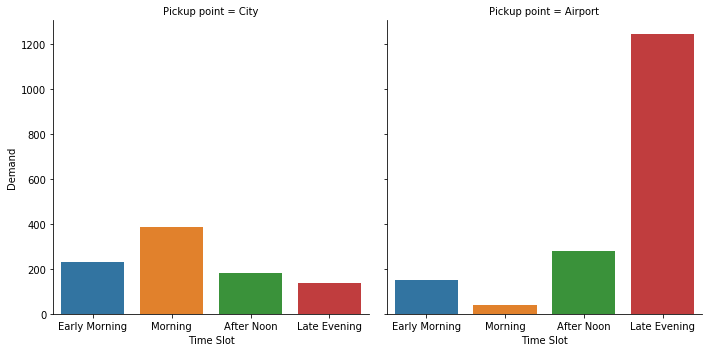

In [50]:
#Request time slots where there are no cars available
sns.catplot(x="Time Slot", y = "Demand", col="Pickup point",col_order=["City", "Airport"], data=UberDF[(UberDF['Gap']==1)&(UberDF['Status']=='No Cars Available')], kind="bar", estimator=np.sum)

While the Demand is more that 1200, the supply is only of the order 450 in the <b> Late Evening time slot </b>, thus there are no cars available to cater user’s request.

#### Solution for this issue for the supply-demand gap

Let's analyze the driver's duration to resolve demand and supply gap

In [392]:
#Calculate the Trip time for the driver from the timestamps
UberDF['Trip Time'] =pd.to_timedelta( UberDF['Drop timestamp'] - UberDF['Request timestamp'] )
UberDF['Trip Time'] = UberDF['Trip Time'].apply(lambda x: x.total_seconds() )

In [395]:
#Calculate the mean Trip time
TripTime = pd.DataFrame(UberDF.pivot_table(values=['Trip Time'],columns = [ 'Time Slot','Pickup point'],
                                     aggfunc={'Trip Time':np.mean  })).reset_index()
TripTime.rename(index=str,columns={0: "Request Time"},inplace=True)
TripTime

,level_0,Time Slot,Pickup point,Request Time
0,Trip Time,Early Morning,Airport,3115.031915
1,Trip Time,Early Morning,City,3213.151659
2,Trip Time,Morning,Airport,3136.726817
3,Trip Time,Morning,City,3193.506986
4,Trip Time,After Noon,Airport,3127.200669
5,Trip Time,After Noon,City,3126.303207
6,Trip Time,Late Evening,Airport,3145.160998
7,Trip Time,Late Evening,City,3103.623608


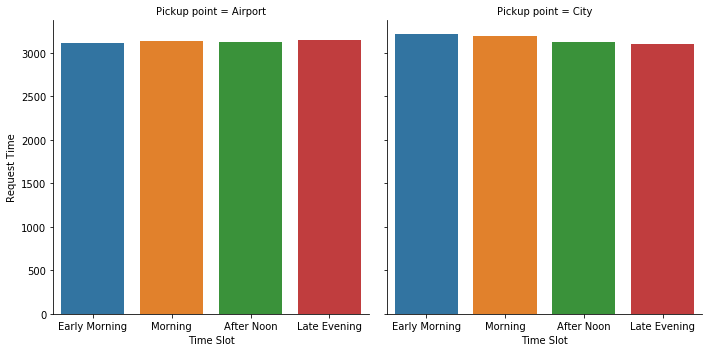

In [386]:
#Plot for the mean trip time
sns.catplot(x="Time Slot", y = "Request Time", col="Pickup point", data=TripTime, kind="bar")

Thus in slots where there are clear difference in the supply of drivers, drivers had to be planned with the duration calculation mentioned above to meet the supply.
